# Agentic RAG

[Retrieval Agents](https://python.langchain.com/v0.2/docs/tutorials/qa_chat_history/#agents) are useful when we want to make decisions about whether to retrieve from an index.

To implement a retrieval agent, we simple need to give an LLM access to a retriever tool.

We can incorporate this into [LangGraph](https://langchain-ai.github.io/langgraph/).

In [28]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI

In [30]:
file_path = './assets-resources/pdfs/human-agent-collab-problem-solving.pdf'

docs = PyPDFLoader(file_path).load_and_split()

len(docs)

23

In [31]:
docs[0:5]

[Document(metadata={'source': './assets-resources/pdfs/human-agent-collab-problem-solving.pdf', 'page': 0}, page_content='Large Language Model-based Human-Agent Collaboration\nfor Complex Task Solving\nXueyang Feng1,2∗, Zhi-Yuan Chen1,2∗, Yujia Qin3, Yankai Lin1,2†\nXu Chen1,2†, Zhiyuan Liu3, Ji-Rong Wen1,2\n1Gaoling School of Artificial Intelligence, Renmin University of China, Beijing, China\n2Beijing Key Laboratory of Big Data Management and Analysis Methods, Beijing, China\n3Department of Computer Science and Technology, Tsinghua University, Beijing, China\n{xueyangfeng, zhiyuanc2001, yankailin, xu.chen}@ruc.edu.cn\nAbstract\nIn recent developments within the research\ncommunity, the integration of Large Language\nModels (LLMs) in creating fully autonomous\nagents has garnered significant interest. De-\nspite this, LLM-based agents frequently demon-\nstrate notable shortcomings in adjusting to dy-\nnamic environments and fully grasping hu-\nman needs. In this work, we introduce the

In [32]:
vectordb = Chroma.from_documents(
    documents=docs,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings()
)

retriever = vectordb.as_retriever()

In [33]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    'retrieve_info_from_paper',
    'Search and return information about a paper.')

tools = [retriever_tool]

In [37]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

In [38]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]



In [50]:
def agent(state: AgentState):
    messages = state['messages']
    model = ChatOpenAI(temperature=0, streaming=True, model='gpt-4o')
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    
    return {'messages': [response]}


In [51]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode, tools_condition

# Graph initiliazation
graph = StateGraph(AgentState)

# Nodes
graph.add_node('agent', agent)
retrieve_node = ToolNode([retriever_tool])
graph.add_node('retrieve', retrieve_node)

# Edges
graph.add_edge(START, 'agent')
graph.add_conditional_edges('agent', tools_condition, {'tools': 'retrieve',END: END})
graph.add_edge('retrieve', 'agent')

compiled_graph = graph.compile()

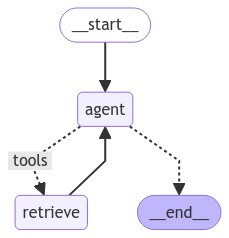

In [52]:
from IPython.display import Image, display

try:
    display(Image(compiled_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [53]:
import pprint

inputs = {
    "messages": [
        ("user", "In this paper how do the authors set up the collaboration between the human and the LLMs?"),
    ]
}
for output in compiled_graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_GgtP493vqXxwhYKfIYkywKyf', 'function': {'arguments': '{"query":"how do the authors set up the collaboration between the human and the LLMs?"}', 'name': 'retrieve_info_from_paper'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_fde2829a40'}, id='run-9e8aab5e-c16a-457c-ad69-195ca283d046-0', tool_calls=[{'name': 'retrieve_info_from_paper', 'args': {'query': 'how do the authors set up the collaboration between the human and the LLMs?'}, 'id': 'call_GgtP493vqXxwhYKfIYkywKyf', 'type': 'tool_call'}])]}
'\n---\n'
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content='Wu et al., 2022a; Mehta et al., 2023). Further-\nmore, there is an increasing emphasis on develop-\ning specialized prompts that motivate LLM-based\nagents to proactively seek human input, thus nu

In [56]:
inputs = {
    "messages": [
        ("user", "What is the name of the framework in this paper that sets up the collaboration between the human and the LLMs?"),
    ]
}

output = compiled_graph.invoke(inputs)

output['messages'][-1].content

'The framework introduced in the paper for setting up collaboration between humans and large language models (LLMs) is called **ReHAC** (Reinforcement Learning-based Human-Agent Collaboration). This method leverages reinforcement learning to dynamically identify the most advantageous moments for human input during the task-solving process.'